In [1]:
########## PACKAGE AND FILE IMPORT ##########

import numpy as np
from numpy.linalg import pinv
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
# type: ignore[import]
from matplotlib.path import Path  # type: ignore[import]
from matplotlib import colors

from fish import Fish
from environment import Environment

In [2]:
# Define fish
num = 7
Nemo_position = np.vstack((np.linspace(0, 0.5, num), np.zeros((num)))) 
Nemo_velocity = np.vstack((-0.1*np.ones(num), np.zeros((num))))
Nemo = Fish(Nemo_position, Nemo_velocity)

# Reinitialize fish position to have reference curvature
angles = Nemo.centerlineScaling * Nemo.waveAmp * np.sin(Nemo.waveNum * Nemo.centerline[1:num-1]) + Nemo.waveOffset
angles = angles.flatten()
current_phi = 0.0
for ii in range(num-1):
    Nemo_position[:, ii+1] = Nemo_position[:, ii] + Nemo.lEdgeRef[ii]*np.array([np.cos(current_phi), np.sin(current_phi)])
    if ii < num-2:
        current_phi += angles[ii]

# Define the environment containing the fish
school = [Nemo]
fish_tank = Environment(school)

In [3]:
fish_tank.run_simulation()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36


KeyboardInterrupt: 

(-0.5, 0.0)

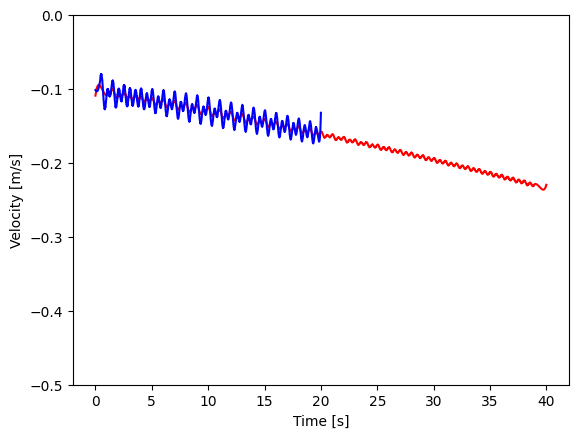

In [66]:
import pickle

# c = shedding
# d = no shedding

with open('c.pkl', 'rb') as f:
    sim_output_c = pickle.load(f)
with open('d.pkl', 'rb') as f:
    sim_output_d = pickle.load(f)
with open('e.pkl', 'rb') as f:
    sim_output_e = pickle.load(f)

head_velocity_c = np.zeros((len(sim_output_c)))
for ii in range(len(sim_output_c)):
    head_velocity_c[ii] = (sim_output_c[ii][14])

head_velocity_d = np.zeros((len(sim_output_d)))
for ii in range(len(sim_output_d)):
    head_velocity_d[ii] = (sim_output_d[ii][14])

head_velocity_e = np.zeros((len(sim_output_e)))
for ii in range(len(sim_output_e)):
    head_velocity_e[ii] = (sim_output_e[ii][14])

from scipy.signal import savgol_filter
smoothed_velocity_c = savgol_filter(head_velocity_c, 81, 4) # window size 51, polynomial order 3
smoothed_velocity_d = savgol_filter(head_velocity_d, 81, 4) # window size 51, polynomial order 3
smoothed_velocity_e = savgol_filter(head_velocity_e, 201, 4) # window size 51, polynomial order 3

time_array = np.linspace(0,20,2001)
time_array_long = np.linspace(0,40,4001)
# plt.plot(time_array, head_velocity_c)
# plt.plot(time_array, smoothed_velocity_c, color = 'red')
plt.plot(time_array_long, smoothed_velocity_e, color = 'red')
# plt.plot(time_array, head_velocity_d)
plt.plot(time_array, smoothed_velocity_d, color = 'blue')
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
# plt.legend(['With Shedding', 'Without Shedding'])
plt.ylim([0,40])
plt.ylim([-0.5,0])


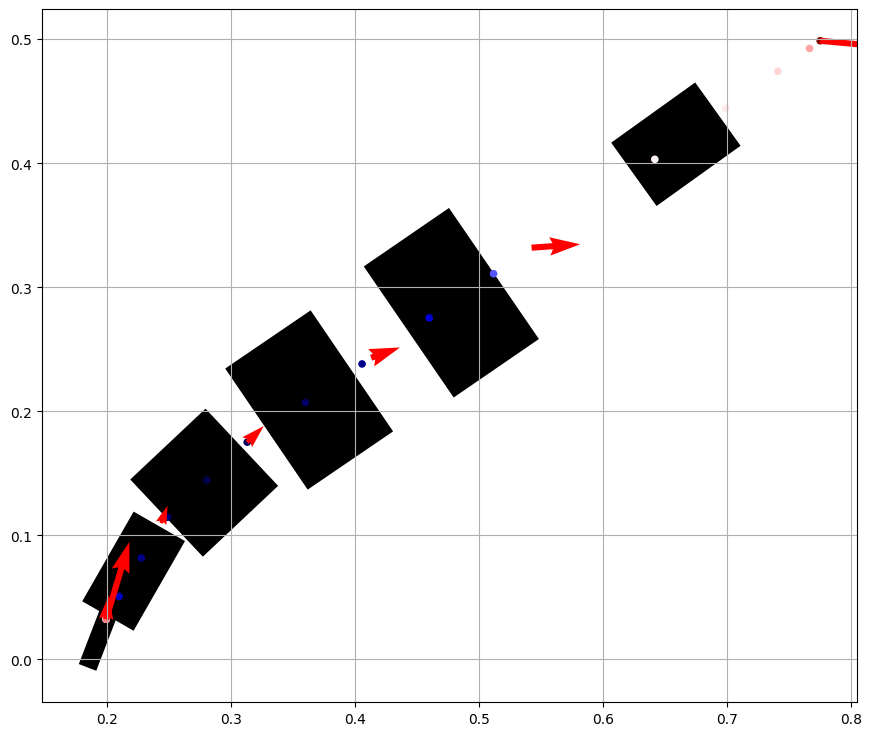

In [10]:
# Use passed-in data if given, otherwise fallback to self attributes
output = fish_tank.output
output_Gamma = fish_tank.output_Gamma

# Define figure
fig, ax = plt.subplots(figsize=(16, 9))

ii = 35

# Clear image and update state at each time step
current_state = output[ii]

vmin = np.min(Nemo.bvs_gamma)
vmax = np.max(Nemo.bvs_gamma)
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)
cmap = plt.get_cmap('seismic') 

# Plot each fish configuration
start = 0
for fish in fish_tank.fishies:

    end = start + 2*fish.N

    # Get node positions from ODE output
    positions = Nemo.positions

    # Calculate centerline segment positions and orientations
    midpoints = (positions[:,0:fish.N-1] + positions[:,1:fish.N])/2
    edges = positions[:,1:fish.N] - positions[:,0:fish.N-1]
    tangents = edges/np.linalg.norm(edges, axis=0)
    normals = np.vstack([-tangents[1,:], tangents[0,:]])

    # Caluclate rectangular segment locations 
    southwestPoints = midpoints - 0.5*tangents*fish.lEdgeRef.T - 0.5*normals*fish.hEdgeRef.T
    northwestPoints = midpoints - 0.5*tangents*fish.lEdgeRef.T + 0.5*normals*fish.hEdgeRef.T
    northeastPoints = midpoints + 0.5*tangents*fish.lEdgeRef.T + 0.5*normals*fish.hEdgeRef.T
    southeastPoints = midpoints + 0.5*tangents*fish.lEdgeRef.T - 0.5*normals*fish.hEdgeRef.T

    # Draw rectangular segments
    for jj in range(fish.N-1):
        rectangleX = [southwestPoints[0, jj], northwestPoints[0, jj],
                    northeastPoints[0, jj], southeastPoints[0, jj]]
        rectangleY = [southwestPoints[1, jj], northwestPoints[1, jj],
                    northeastPoints[1, jj], southeastPoints[1, jj]]
        ax.fill(rectangleX, rectangleY, 'k') #, label='Segments' if jj == 0 else "")

    start = end + 2*fish.N

    # Plot freestream lines of velocity field
    x_targets = np.linspace(2.4,3.2,50)
    y_targets = np.linspace(-0.4,0.4,50)
    X_targets, Y_targets = np.meshgrid(x_targets,y_targets)
    Z_targets = X_targets + 1j*Y_targets
    velocity_quivers = np.zeros_like(Z_targets)
    # potential = np.zeros_like(Z_targets)

    # Plot free vortex street
    bound_vortex_gamma = fish.bvs_gamma
    bound_vortices = fish.bvs_positions.reshape((2,fish.bvs_N), order='F')
    sc = ax.scatter(bound_vortices[0,:], bound_vortices[1,:], c=bound_vortex_gamma, 
    cmap=cmap, norm=norm, s=20)

    # Add contribution of bound vortices to flow potential
    Z_sources = bound_vortices[0,:] + 1j*bound_vortices[1,:]
    for ii in range(fish.bvs_N):
        velocity_quivers += 1j * bound_vortex_gamma[ii] * (Z_targets - Z_sources[ii]) / (2 * np.pi * np.abs(Z_targets - Z_sources[ii]) ** 2)
        # potential += bound_vortex_gamma[ii] * fish.bvs_length[ii] * np.log(Z_targets - Z_sources[ii]) / (2 * np.pi * 1j)

# plt.quiver(X_targets, Y_targets, np.real(velocity_quivers), np.imag(velocity_quivers), color='blue')
# plt.contour(X_targets, Y_targets, np.imag(potential), levels=25, cmap="turbo")
# plt.quiver(bound_vortices[0,:], bound_vortices[1,:], x_ddot[0,:], x_ddot[1,:], color='red')
plt.quiver(Nemo.positions[0,:], Nemo.positions[1,:], Nemo.velocities[0,:], Nemo.velocities[1,:], color='red')

# Plotting parameters
# plt.xlim(2.4,3.2)
# plt.ylim(-0.4,0.4)
ax.set_aspect('equal')
ax.grid(True)
# ax.legend()
plt.pause(0.1)